# Análisis Exploratorio de Datos (EDA) - Home Credit Default Risk
## Introducción
El acceso al crédito es un factor clave para el desarrollo financiero de las personas, pero evaluar la solvencia de los solicitantes sigue siendo un desafío crucial para las instituciones financieras. La competencia Home Credit Default Risk, organizada en Kaggle, proporciona un conjunto de datos con información detallada sobre clientes de Home Credit, una entidad financiera que ofrece préstamos a personas con historial crediticio limitado o inexistente.

El objetivo de este análisis es comprender las características de los datos disponibles, identificar patrones y relaciones entre las variables, y detectar posibles factores que puedan influir en la capacidad de pago de los clientes. Para ello, realizaremos un Análisis Exploratorio de Datos (EDA), donde exploraremos la estructura de los datos, analizaremos distribuciones, identificaremos valores atípicos y estudiaremos correlaciones relevantes.

## Objetivos del EDA
1. Comprender la estructura de los datos: Examinar el número de observaciones, tipos de variables y la presencia de valores nulos o inconsistencias.
2. Explorar la distribución de las variables: Identificar características generales de los clientes, como edad, ingresos y estado laboral.
3. Analizar la variable objetivo (TARGET) y su relación con otras variables: Detectar patrones que diferencien a los clientes que cumplen con sus pagos de aquellos que no.
4. Estudiar correlaciones y relaciones entre variables: Determinar qué factores pueden estar asociados con el riesgo de incumplimiento.
Visualizar los datos de manera efectiva: Utilizar gráficos e histogramas para detectar tendencias y posibles anomalías.

### Añadimos un script para potenciar el funcionamiento del jupyter notebook

In [35]:
import os
import gc
import multiprocessing
import numpy as np

# 🌟 1️⃣ Verificar si hay GPU disponible (para NVIDIA)
try:
    import torch
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        print(f"✅ GPU Detectada: {gpu_name}")
        os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Debug de errores de GPU
        torch.cuda.empty_cache()  # Liberar caché de la GPU
    else:
        print("⚠️ No se detectó GPU. Se usará CPU.")
except ImportError:
    print("⚠️ PyTorch no está instalado. Instálalo con: pip install torch torchvision torchaudio")

# 🔥 2️⃣ Verificar si TensorFlow puede usar la GPU
try:
    import tensorflow as tf
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"✅ TensorFlow detectó {len(gpus)} GPU(s).")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Evita problemas de memoria
    else:
        print("⚠️ TensorFlow no detectó GPUs. Se usará CPU.")
except ImportError:
    print("⚠️ TensorFlow no está instalado. Instálalo con: pip install tensorflow-gpu")

# 🚀 3️⃣ Configurar uso de múltiples núcleos de CPU
cpu_cores = multiprocessing.cpu_count()
os.environ["OMP_NUM_THREADS"] = str(cpu_cores)
print(f"✅ Usando {cpu_cores} núcleos de CPU.")

# 🛠️ 4️⃣ Aumentar límite de memoria en Jupyter Notebook
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
print("✅ Configuración de memoria ajustada para máximo rendimiento.")

# 🔍 5️⃣ Ver información del sistema
try:
    os.system("nvidia-smi")  # Mostrar estado de la GPU en terminal
except:
    print("⚠️ No se pudo ejecutar nvidia-smi. Verifica si tienes GPU NVIDIA.")

# 🏎️ 6️⃣ Configuración de NumPy para máxima velocidad
np.set_printoptions(precision=5, suppress=True)  # Evitar notación científica innecesaria
np.show_config()

# 🔄 7️⃣ Función para liberar memoria (Útil después de procesos pesados)
def liberar_memoria():
    gc.collect()
    try:
        torch.cuda.empty_cache()
    except NameError:
        pass  # No hay torch instalado
    try:
        tf.keras.backend.clear_session()
    except NameError:
        pass  # No hay TensorFlow instalado
    print("🧹 Memoria liberada.")

print("🚀 Configuración de alto rendimiento aplicada. ¡Listo para trabajar!")

⚠️ No se detectó GPU. Se usará CPU.
⚠️ TensorFlow no detectó GPUs. Se usará CPU.
✅ Usando 12 núcleos de CPU.
✅ Configuración de memoria ajustada para máximo rendimiento.
Build Dependencies:
  blas:
    detection method: pkgconfig
    found: true
    include directory: C:/Users/ASUS/anaconda3/Library/include
    lib directory: C:/Users/ASUS/anaconda3/Library/lib
    name: mkl-sdl
    openblas configuration: unknown
    pc file directory: C:\b\abs_c1ywpu18ar\croot\numpy_and_numpy_base_1708638681471\_h_env\Library\lib\pkgconfig
    version: '2023.1'
  lapack:
    detection method: internal
    found: true
    include directory: unknown
    lib directory: unknown
    name: dep1583119523984
    openblas configuration: unknown
    pc file directory: unknown
    version: 1.26.4
Compilers:
  c:
    commands: cl.exe
    linker: link
    name: msvc
    version: 19.29.30154
  c++:
    commands: cl.exe
    linker: link
    name: msvc
    version: 19.29.30154
  cython:
    commands: cython
    link

## Carga de datos

In [3]:
import pandas as pd
import numpy as np
import os

# Lista de archivos en la carpeta
archivos = {
    "train_final":"train_final.csv",
    "test_final": "test_final.csv"
}
# Cargar archivos sin procesar
data = {nombre: pd.read_csv(archivo, low_memory=False) for nombre, archivo in archivos.items()}

In [5]:
print("Shape del dataset de entrenamiento final:", data["train_final"].shape)
print("Shape del dataset de prueba final:", data["test_final"].shape)

Shape del dataset de entrenamiento final: (1430155, 180)
Shape del dataset de prueba final: (257457, 179)


## Diccionario de datos

A continuación podrán observar el diccionario de los datos con los que vamos a trabajar.

In [7]:
import pandas as pd
import numpy as np
import os

# Intenta leer el archivo con diferentes codificaciones
try:
    description = pd.read_csv("HomeCredit_Columns_description.csv", encoding="utf-8")
except UnicodeDecodeError:
    description = pd.read_csv("HomeCredit_Columns_description.csv", encoding="ISO-8859-1")  # Alternativa

# Extraer train_final
train_final = data["train_final"]

# Extraer las variables únicas de train_final en un DataFrame
train_variables = pd.DataFrame(train_final.columns, columns=["Row"]).drop_duplicates()

# Eliminar duplicados en el DataFrame de descripciones para evitar repetición de variables
description_cleaned = description[['Row', 'Description']].drop_duplicates()

# Cruzar con el DataFrame de descripciones
merged_df = train_variables.merge(description_cleaned, on="Row", how="left")

# Configurar Pandas para mostrar toda la tabla sin truncamientos
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.max_colwidth', None)  # Evitar que se corte el texto en columnas largas
pd.set_option('display.expand_frame_repr', False)  # Evita que las columnas se dividan en varias líneas

# Mostrar la tabla completa en Jupyter Notebook
from IPython.display import display
display(merged_df)


,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,NaN
2,NAME_CONTRACT_TYPE_x,NaN
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
5,FLAG_OWN_REALTY,Flag if client owns a house or flat
6,CNT_CHILDREN,Number of children the client has
7,AMT_INCOME_TOTAL,Income of the client
8,AMT_CREDIT_x,NaN
9,AMT_ANNUITY_x,NaN


## Análisis Descriptivo de los datos

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, kstest, skew

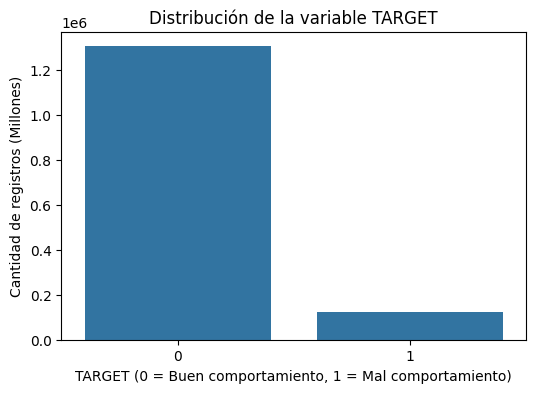

Proporción de la variable TARGET:
 TARGET
0    91.37576
1     8.62424
Name: proportion, dtype: float64


In [11]:
# Distribución de TARGET
plt.figure(figsize=(6, 4))
sns.countplot(x=train_final["TARGET"])
plt.title("Distribución de la variable TARGET")
plt.xlabel("TARGET (0 = Buen comportamiento, 1 = Mal comportamiento)")
plt.ylabel("Cantidad de registros (Millones)")
plt.show()

# Proporción de clases
target_counts = train_final["TARGET"].value_counts(normalize=True) * 100
print("Proporción de la variable TARGET:\n", target_counts)

## Análisis de la Distribución de la Variable TARGET

El gráfico revela un marcado desbalance en la distribución de la variable **TARGET**, donde:

- **91.38%** de los clientes presentan un **buen comportamiento de pago** (clase mayoritaria).
- **8.62%** de los clientes tienen **problemas de pago** (clase minoritaria).

### Implicaciones para el Modelado Predictivo
Este desbalance puede afectar la capacidad de los modelos de aprendizaje automático, ya que tienden a sesgarse hacia la clase mayoritaria, reduciendo su capacidad para identificar correctamente a los clientes con mayor riesgo de incumplimiento.

### Estrategias para Mitigar el Desequilibrio
Para mejorar la precisión del modelo y evitar sesgos, se pueden aplicar técnicas como:
- **Submuestreo** de la clase mayoritaria.
- **Sobremuestreo** de la clase minoritaria (SMOTE).
- **Asignación de pesos a las clases** en algoritmos de clasificación.

### Conclusión
El desbalance en **TARGET** destaca la necesidad de aplicar estrategias de balanceo para mejorar la capacidad predictiva del modelo y optimizar la evaluación de riesgo crediticio, permitiendo decisiones más precisas en la concesión de préstamos.


## Identificación de datos nulos

In [13]:
# Calcular porcentaje de valores nulos por variable
missing_values = train_final.isnull().sum() / len(train_final) * 100

# Mostrar las variables con más del 50% de valores nulos
high_missing = missing_values[missing_values > 50].sort_values(ascending=False)
print("Variables con más del 50% de valores nulos:\n", high_missing)


Variables con más del 50% de valores nulos:
 RATE_INTEREST_PRIVILEGED        99.665001
RATE_INTEREST_PRIMARY           99.665001
AMT_PAYMENT_CURRENT_mean        96.295646
AMT_BALANCE_std                 94.572057
AMT_DRAWINGS_CURRENT_sum        94.526118
AMT_BALANCE_min                 94.526118
AMT_PAYMENT_CURRENT_sum         94.526118
AMT_DRAWINGS_CURRENT_mean       94.526118
AMT_BALANCE_mean                94.526118
MONTHS_BALANCE_count            94.526118
AMT_BALANCE_max                 94.526118
AMT_CREDIT_LIMIT_ACTUAL_mean    94.526118
COMMONAREA_MEDI                 69.607980
COMMONAREA_AVG                  69.607980
COMMONAREA_MODE                 69.607980
NONLIVINGAPARTMENTS_AVG         69.211729
NONLIVINGAPARTMENTS_MODE        69.211729
NONLIVINGAPARTMENTS_MEDI        69.211729
FONDKAPREMONT_MODE              68.131286
LIVINGAPARTMENTS_AVG            68.128559
LIVINGAPARTMENTS_MODE           68.128559
LIVINGAPARTMENTS_MEDI           68.128559
FLOORSMIN_AVG                  

## Análisis de Variables con Alto Porcentaje de Valores Nulos

El análisis de valores faltantes revela que varias variables contienen un porcentaje significativo de datos nulos, lo que podría afectar la calidad del modelo y requerir estrategias de imputación o eliminación.

### 1. Variables con Mayor Porcentaje de Datos Faltantes
- **RATE_INTEREST_PRIVILEGED (99.67%) y RATE_INTEREST_PRIMARY (99.67%)**: Estas variables, relacionadas con tasas de interés, presentan una ausencia casi total, lo que sugiere que la información sobre tasas preferenciales y primarias no está disponible para la mayoría de los registros.
- **AMT_PAYMENT_CURRENT_mean (96.3%) y AMT_BALANCE_std (94.57%)**: Estas variables financieras, derivadas de la reagrupación de datos de crédito, muestran una alta cantidad de valores nulos, lo que podría indicar falta de reportes en el historial crediticio o limitaciones en la base de datos original.
- **AMT_BALANCE_min (94.52%) y AMT_BALANCE_max (94.52%)**: La ausencia significativa en estos campos sugiere que muchos clientes no cuentan con información detallada sobre sus saldos históricos.

### 2. Variables Relacionadas con Características de Vivienda
- **COMMONAREA_AVG (69.61%) y NONLIVINGAPARTMENTS_AVG (69.21%)**: La falta de datos en estas variables puede deberse a registros incompletos sobre propiedades inmobiliarias.
- **OWN_CAR_AGE (66.26%)**: La edad del automóvil del cliente está ausente en un gran número de registros, lo que puede deberse a que muchos clientes no poseen un vehículo.

### Conclusión
El alto porcentaje de valores nulos en variables clave sugiere la necesidad de aplicar estrategias de imputación, como reemplazo por la mediana o clustering para estimar valores faltantes. En casos donde la información ausente sea demasiado significativa y la variable tenga baja importancia en la predicción del riesgo crediticio, la eliminación podría ser una alternativa viable para optimizar el modelo.


## Analisis de Correlación (Variables Numéricas)

In [15]:
import pandas as pd

# Ver qué columnas son categóricas
categorical_cols = train_final.select_dtypes(include=['object']).columns

# Eliminar columnas categóricas antes de calcular la correlación
train_numeric = train_final.drop(columns=categorical_cols)

# Calcular correlación solo en variables numéricas y tomar valores absolutos
correlations = train_numeric.corr()["TARGET"].abs().sort_values(ascending=False)

# Tomar las 10 variables más correlacionadas con TARGET (excluyendo TARGET en sí mismo)
top_correlated_vars = correlations.iloc[1:11]  # Excluye TARGET en sí mismo

# Mostrar resultados
print("Top 10 variables más correlacionadas (positiva o negativamente) con TARGET:\n", top_correlated_vars)


Top 10 variables más correlacionadas (positiva o negativamente) con TARGET:
 EXT_SOURCE_3                   0.188383
EXT_SOURCE_2                   0.155210
EXT_SOURCE_1                   0.153187
AMT_BALANCE_mean               0.086428
DAYS_BIRTH                     0.074314
AMT_BALANCE_max                0.068921
AMT_BALANCE_min                0.063483
REGION_RATING_CLIENT_W_CITY    0.059832
AMT_BALANCE_std                0.059429
DAYS_LAST_PHONE_CHANGE         0.058111
Name: TARGET, dtype: float64


## Interpretación

El análisis de correlación revela las variables con mayor relación con **TARGET**, lo que permite identificar los factores más influyentes en la predicción del incumplimiento crediticio.

### 1. Puntajes de Riesgo Externo
- Las variables con mayor correlación son:
  - **EXT_SOURCE_3 (0.188)**
  - **EXT_SOURCE_2 (0.155)**
  - **EXT_SOURCE_1 (0.153)**
- Esto indica que los puntajes de riesgo externo tienen un impacto significativo en la probabilidad de incumplimiento, sugiriendo que estos indicadores son cruciales para evaluar la solvencia de los clientes.

### 2. Factores Financieros
- Variables como:
  - **AMT_BALANCE_mean (0.086)**
  - **AMT_BALANCE_max (0.069)**
- Estas relaciones sugieren que los saldos promedios y los valores extremos en cuentas previas están vinculados al comportamiento crediticio, lo que podría reflejar hábitos de gasto o acumulación de deuda.

### 3. Factores Demográficos y de Información de Contacto
- **DAYS_BIRTH (0.074)** muestra una relación moderada con TARGET, lo que sugiere que la edad del cliente puede influir en la probabilidad de incumplimiento.
- **DAYS_LAST_PHONE_CHANGE (0.058)** indica que cambios recientes en la información de contacto pueden ser un factor relevante en la evaluación del riesgo crediticio.

### Conclusión
Los puntajes de riesgo externo son los predictores más fuertes de incumplimiento, mientras que variables financieras y demográficas también pueden aportar información útil para la evaluación del riesgo crediticio. La combinación de estos factores podría mejorar la precisión de los modelos de predicción.


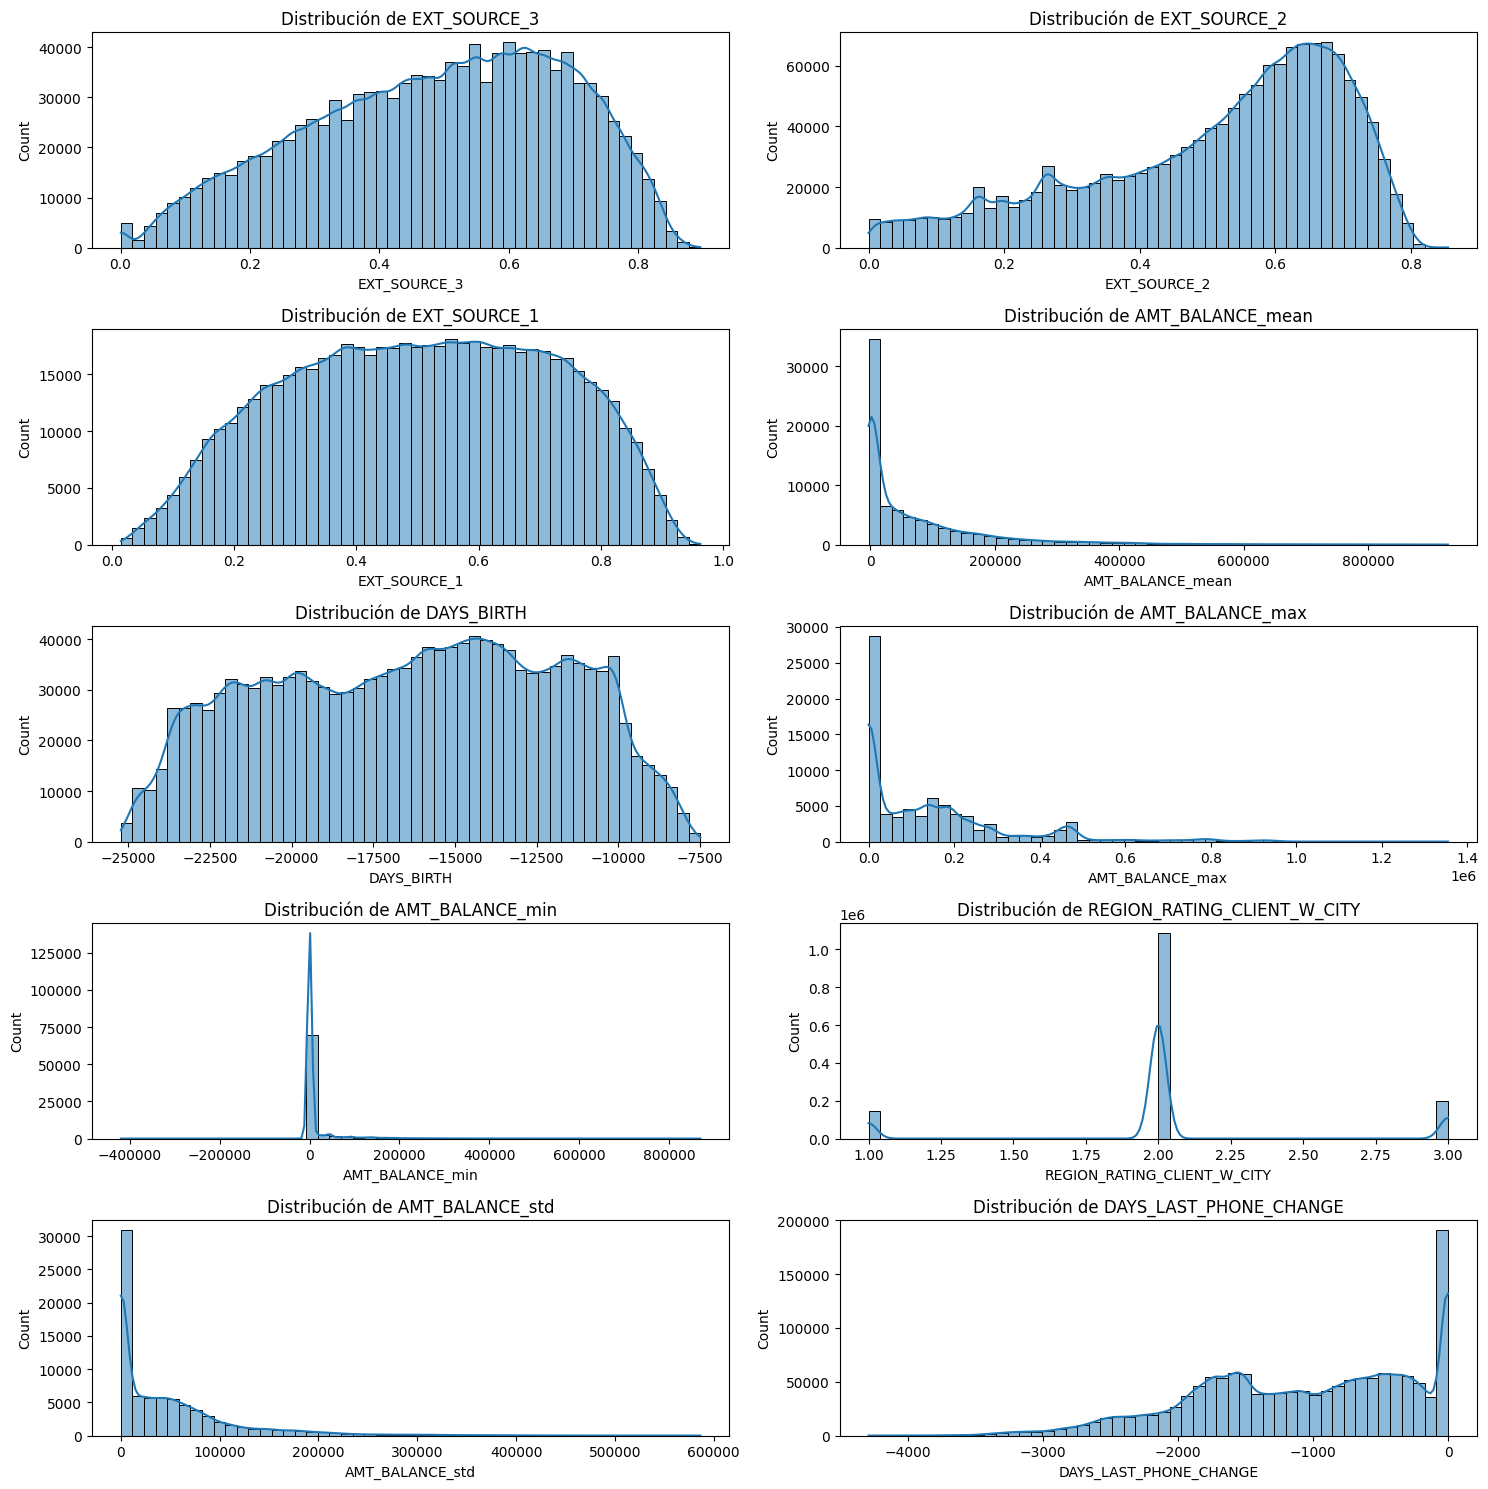

In [17]:
# Visualizar la distribución de las variables más correlacionadas
fig, axes = plt.subplots(5, 2, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(top_correlated_vars.index):
    sns.histplot(train_final[col].dropna(), bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribución de {col}")

plt.tight_layout()
plt.show()

## Análisis Visual de las Distribuciones de las Variables Más Correlacionadas con TARGET
Veamos que conclusiones podemos sacar de las distribuciones observadas


### 1. EXT_SOURCE_3, EXT_SOURCE_2 y EXT_SOURCE_1
- Estas variables presentan distribuciones continuas y mayormente uniformes, aunque con ligeros sesgos hacia valores intermedios.
- **EXT_SOURCE_2** muestra una distribución más sesgada a la derecha, lo que sugiere que una mayor cantidad de clientes tiene puntajes de riesgo más altos.
- En general, los puntajes de riesgo externo parecen estar bien distribuidos entre los clientes, con una mayor concentración en valores medios y altos.

### 2. DAYS_BIRTH
- La distribución es **bimodal** y refleja la edad de los clientes en días negativos (al representar días desde el nacimiento).
- Se observa una mayor concentración en ciertos rangos etarios, lo que podría estar relacionado con criterios de selección o segmentación en el otorgamiento de créditos.
- La presencia de picos sugiere que algunos grupos de edad tienen más representación en la muestra.

### 3. AMT_BALANCE_mean y AMT_BALANCE_max
- Ambas variables presentan distribuciones **altamente sesgadas a la derecha**, con una gran cantidad de valores cercanos a cero y algunos valores extremadamente altos.
- Esto indica que la mayoría de los clientes mantiene **saldos bajos en sus cuentas de crédito**, mientras que una minoría maneja montos significativamente elevados.
- Este patrón puede reflejar diferencias en los niveles de crédito otorgado o en los hábitos financieros de los clientes.

### Conclusión
Las distribuciones muestran patrones claros que pueden influir en la segmentación y análisis de riesgo crediticio. La fuerte asimetría en variables como **AMT_BALANCE_mean y AMT_BALANCE_max** sugiere la necesidad de transformaciones para mejorar su manejo en modelos de predicción. Asimismo, la bimodalidad de **DAYS_BIRTH** podría indicar diferencias estructurales en la población analizada.


In [19]:
distribution_tests = {}
for col in top_correlated_vars.index:
    data = train_final[col].dropna()
    if len(data) > 5000:  # Limitar tamaño para pruebas estadísticas
        data = data.sample(5000, random_state=42)

    # Pruebas de normalidad
    shapiro_test = shapiro(data)[1]  # p-valor
    ks_test = kstest(data, 'norm')[1]  # p-valor
    skewness = skew(data)

    distribution_tests[col] = {
        "Shapiro-Wilk p-value": shapiro_test,
        "Kolmogorov-Smirnov p-value": ks_test,
        "Asimetría": skewness
    }

# Mostrar resultados de las pruebas de distribución
distribution_tests_df = pd.DataFrame(distribution_tests).T
print("Pruebas de normalidad y asimetría:\n", distribution_tests_df)


Pruebas de normalidad y asimetría:
                              Shapiro-Wilk p-value  Kolmogorov-Smirnov p-value  Asimetría
EXT_SOURCE_3                         1.212785e-28                         0.0  -0.299534
EXT_SOURCE_2                         1.469559e-44                         0.0  -0.797425
EXT_SOURCE_1                         2.754945e-27                         0.0  -0.094627
AMT_BALANCE_mean                     4.496601e-69                         0.0   2.399885
DAYS_BIRTH                           1.803122e-31                         0.0  -0.099533
AMT_BALANCE_max                      1.388065e-61                         0.0   1.680782
AMT_BALANCE_min                      1.876203e-88                         0.0   6.408558
REGION_RATING_CLIENT_W_CITY          9.416145e-72                         0.0   0.102572
AMT_BALANCE_std                      1.722200e-65                         0.0   2.131571
DAYS_LAST_PHONE_CHANGE               1.264442e-37                         

## Análisis de Normalidad y Asimetría

### 1. Normalidad (Pruebas de Shapiro-Wilk y Kolmogorov-Smirnov)

Todas las variables presentan p-valores extremadamente bajos (≈0.0) en ambas pruebas, lo que indica que ninguna de ellas sigue una distribución normal. Esto sugiere que los datos contienen sesgos o colas largas que los alejan de la distribución gaussiana, lo cual debe ser considerado al seleccionar técnicas estadísticas o modelos de aprendizaje automático.

### 2. Asimetría

- **EXT_SOURCE_3, EXT_SOURCE_2 y EXT_SOURCE_1**: Presentan una **leve asimetría negativa**, lo que indica una ligera concentración de valores altos y una cola más extendida hacia la izquierda.
- **DAYS_BIRTH y DAYS_LAST_PHONE_CHANGE**: Muestran una **asimetría negativa moderada**, lo que sugiere que la mayoría de los valores se encuentran en la parte alta, con una distribución sesgada hacia valores menores.
- **AMT_BALANCE_mean, AMT_BALANCE_max y AMT_BALANCE_std**: Exhiben una **asimetría positiva alta**, lo que significa que la mayoría de los valores son pequeños, pero algunos valores extremos empujan la distribución hacia la derecha.
- **AMT_BALANCE_min**: Presenta la mayor **asimetría positiva (6.40)**, lo que indica una distribución altamente sesgada hacia valores muy pequeños con la presencia de observaciones extremadamente grandes.

### Conclusión

Las variables analizadas **no siguen una distribución normal**, lo que implica que métodos estadísticos basados en la suposición de normalidad pueden no ser adecuados. Además, la fuerte asimetría observada en variables como **AMT_BALANCE_min** sugiere la presencia de valores atípicos o distribuciones altamente sesgadas, lo que puede afectar la interpretación y el modelado de datos. En consecuencia, se recomienda aplicar transformaciones o métodos robustos que manejen estas características para mejorar la calidad del análisis.


### Analisis de multicolinealidad (variables numéricas)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_26032\4061662299.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  top_correlated_vars["TARGET"] = correlations[0]  # Añade TARGET a la lista


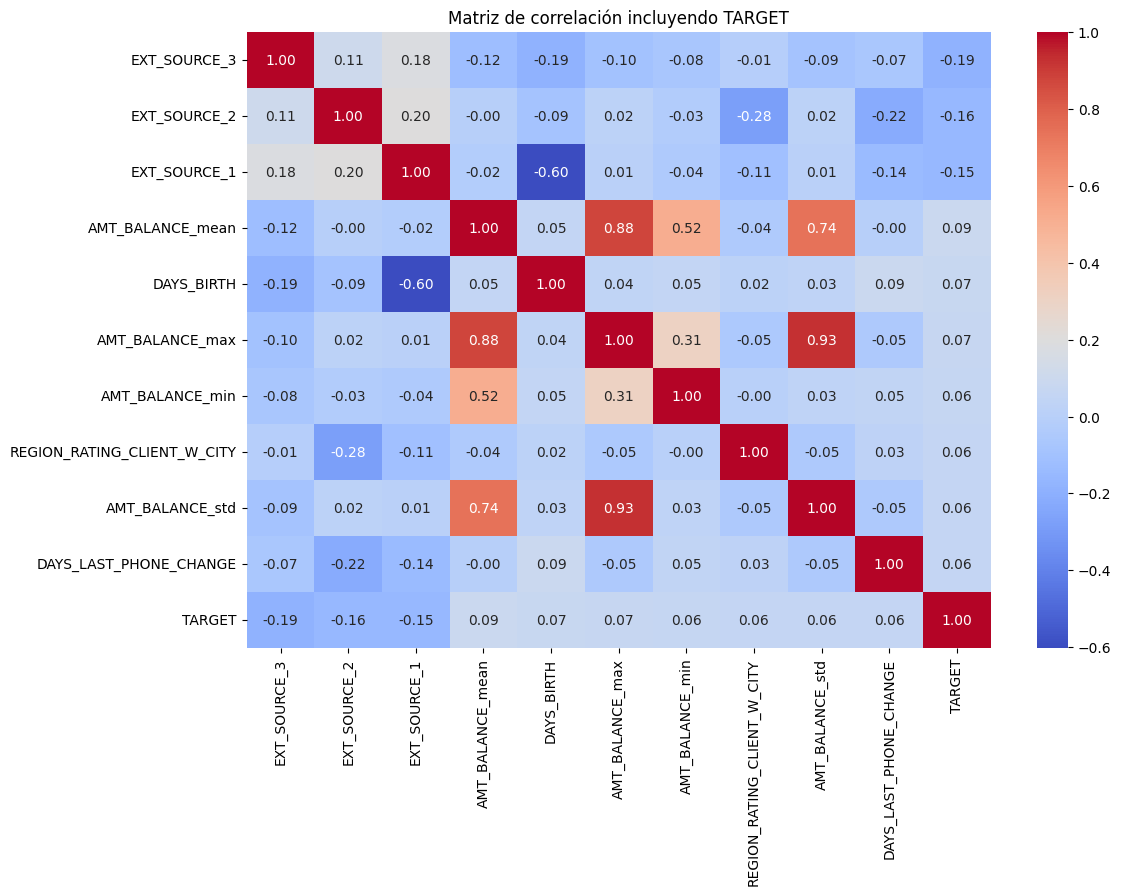

In [21]:
# Añadir TARGET manualmente al conjunto de variables más correlacionadas
top_correlated_vars = correlations[1:11]  # Excluye TARGET en sí mismo
top_correlated_vars["TARGET"] = correlations[0]  # Añade TARGET a la lista

# Generar la matriz de correlación incluyendo TARGET
plt.figure(figsize=(12, 8))
sns.heatmap(train_final[top_correlated_vars.index].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación incluyendo TARGET")
plt.show()


## Interpretación de Multicolinealidad en la Matriz de Correlación

Observando la matriz de correlación, se pueden identificar varias variables con alta correlación entre sí, lo que sugiere la presencia de multicolinealidad. Esto podría generar redundancia en el modelo y afectar su interpretación y desempeño. A continuación, se destacan las principales relaciones detectadas:

### Variables con alta correlación

1. **AMT_BALANCE_max y AMT_BALANCE_std** → Correlación de **0.93**  
   - Estas dos variables están fuertemente correlacionadas, lo que indica que aportan información similar. Se recomienda evaluar si una de ellas puede ser eliminada.

2. **AMT_BALANCE_max y AMT_BALANCE_mean** → Correlación de **0.88**  
   - La relación es muy fuerte, lo que sugiere que ambas variables contienen información redundante. Conservar solo una de ellas podría simplificar el modelo sin perder valor predictivo.

3. **AMT_BALANCE_std y AMT_BALANCE_mean** → Correlación de **0.74**  
   - Aunque menor que las anteriores, esta correlación sigue siendo significativa y puede justificar la eliminación de una de las variables.

4. **AMT_BALANCE_min y AMT_BALANCE_mean** → Correlación de **0.52**  
   - La relación es menos pronunciada, pero sigue indicando que ambas variables pueden estar capturando información similar.

5. **EXT_SOURCE_1 y DAYS_BIRTH** → Correlación de **-0.60**  
   - Aunque se trata de una correlación negativa, indica que estas variables están inversamente relacionadas. No es un caso típico de multicolinealidad, pero es importante evaluar si ambas aportan información única o si una de ellas puede ser descartada.

### Conclusión

Para reducir la multicolinealidad y mejorar la eficiencia del modelo, se recomienda considerar la eliminación de algunas variables:

- **AMT_BALANCE_std o AMT_BALANCE_max**, ya que tienen una correlación de 0.93.  
- **AMT_BALANCE_mean o AMT_BALANCE_max**, debido a su correlación de 0.88.  
- **EXT_SOURCE_1 o DAYS_BIRTH**, dependiendo del impacto en la predicción, dado que presentan una relación inversa significativa.  

Reducir la redundancia en los datos puede mejorar la estabilidad y la interpretabilidad del modelo sin afectar su capacidad predictiva.


## Análisis de correlación (variables categóricas)

A continuación vamos a realizar un análisis de correlación de la variable target contra las variables categoricas de nuestra base.

También verificaremos si existe variables altamente correlacionadas entre sí, para evitar multicolinealidad.

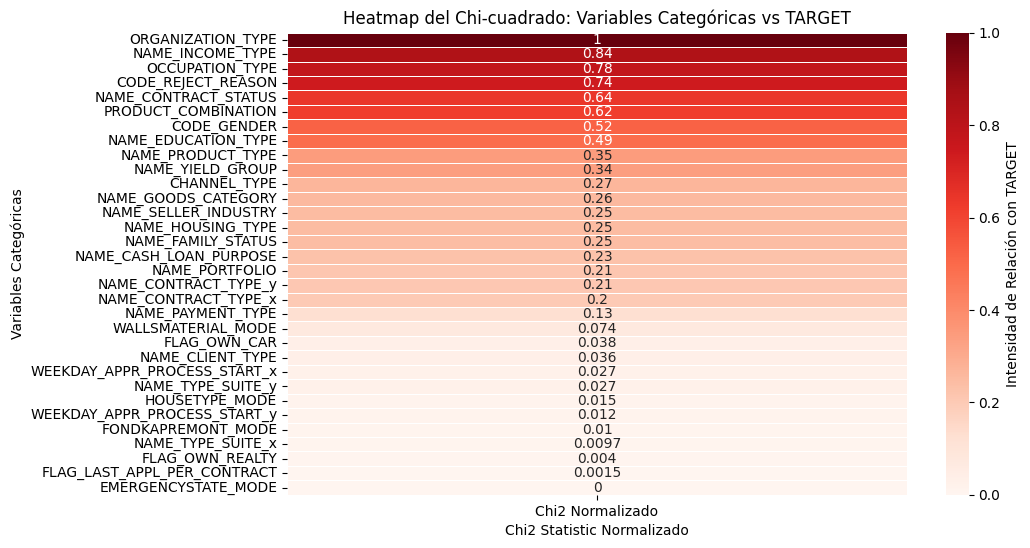

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

# Filtrar solo variables categóricas
categorical_vars = train_final.select_dtypes(include=['object']).columns

# Almacenar resultados de chi-cuadrado
chi2_results = []

for cat_var in categorical_vars:
    # Crear tabla de contingencia
    contingency_table = pd.crosstab(train_final[cat_var], train_final["TARGET"])
    
    # Aplicar prueba de chi-cuadrado
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    # Guardar resultados
    chi2_results.append((cat_var, chi2_stat, p_value))

# Convertir a DataFrame
chi2_df = pd.DataFrame(chi2_results, columns=["Variable", "Chi2 Statistic", "P-value"])
chi2_df = chi2_df.sort_values("Chi2 Statistic", ascending=False)  # Ordenar por impacto

# Normalizar el Chi2 Statistic para mejor visualización (opcional)
chi2_df["Chi2 Normalizado"] = (chi2_df["Chi2 Statistic"] - chi2_df["Chi2 Statistic"].min()) / (chi2_df["Chi2 Statistic"].max() - chi2_df["Chi2 Statistic"].min())

# Crear heatmap solo con Chi2 Statistic normalizado
plt.figure(figsize=(10, 6))
sns.heatmap(
    chi2_df.set_index("Variable")[["Chi2 Normalizado"]],  # Solo usamos el Chi2 normalizado
    cmap="Reds",  # Paleta llamativa
    annot=True,  # Mostrar valores
    linewidths=0.5,
    cbar_kws={'label': 'Intensidad de Relación con TARGET'}
)
plt.title("Heatmap del Chi-cuadrado: Variables Categóricas vs TARGET")
plt.xlabel("Chi2 Statistic Normalizado")
plt.ylabel("Variables Categóricas")
plt.show()



## Análisis del Heatmap de Chi-cuadrado: Variables Categóricas vs TARGET

El análisis de chi-cuadrado revela que ciertas variables categóricas tienen una fuerte relación con **TARGET**, lo que indica su relevancia en la predicción del riesgo crediticio.

### 1. Variables con Mayor Relación con TARGET
Las siguientes variables presentan una alta intensidad de relación con TARGET, lo que sugiere que influyen significativamente en la probabilidad de incumplimiento crediticio:
- **ORGANIZATION_1.0 (0.84)**: El tipo de organización donde trabaja el cliente es la variable categórica más relevante, lo que indica que ciertos sectores o tipos de empleo están más asociados con riesgo de incumplimiento.
- **NAME_INCOME_T84E (0.78)**: La fuente de ingresos del cliente es un factor clave, lo que sugiere que ciertos tipos de ingresos (asalariado, autónomo, pensionado, etc.) pueden estar correlacionados con diferentes niveles de riesgo crediticio.
- **OCCUPATION_T8PE (0.74)**: La ocupación del cliente influye en la capacidad de pago, posiblemente debido a la estabilidad laboral y nivel de ingresos.
- **CODE_REJECT_R7ASON (0.64)**: Los motivos de rechazo de solicitudes anteriores muestran una relación moderadamente alta con TARGET, lo que sugiere que clientes con antecedentes de rechazo pueden tener un mayor riesgo de incumplimiento.
- **NAME_CONTRACT_S4ATUS (0.62)**: El estado del contrato previo puede indicar la tendencia de un cliente a cumplir o no con sus compromisos financieros.

### 2. Variables con Relación Moderada
- **PRODUCT_CO6BINATION (0.52)**: El tipo de combinación de productos financieros adquiridos por el cliente parece tener una influencia en el comportamiento crediticio.
- **C52E_GENDER (0.49)**: Aunque menos significativa que las anteriores, el género del cliente muestra cierta relación con el riesgo de incumplimiento.
- **NAME_EDU49TION_TYPE (0.35)** y **NAME_PRODUCT_TYPE (0.34)**: El nivel educativo y el tipo de producto contratado pueden influir en la probabilidad de impago, aunque en menor medida.

### 3. Variables con Impacto Insignificante
Algunas variables presentan una relación prácticamente nula con TARGET, lo que indica que su influencia en el riesgo crediticio es mínima:
- **FLAG_OWN_REALTY (0.004)**: La propiedad de vivienda no parece ser un factor determinante en la capacidad de pago del cliente.
- **FLAG_LAST_APPL_PER_CONTRACT (0.0015)** y **EMERGENCYSTATE_MODE (0.0)**: Estas variables tienen un impacto despreciable, lo que sugiere que pueden eliminarse sin afectar el desempeño del modelo.

### Conclusión
Las variables con mayor relación con **TARGET**, como **ORGANIZATION_TYPE, NAME_INCOME_TYPE y OCCUPATION_TYPE**, deben priorizarse en el análisis y modelado del riesgo crediticio. En contraste, variables con influencia insignificante pueden eliminarse para reducir la dimensionalidad y mejorar la eficiencia del modelo sin perder información relevante.


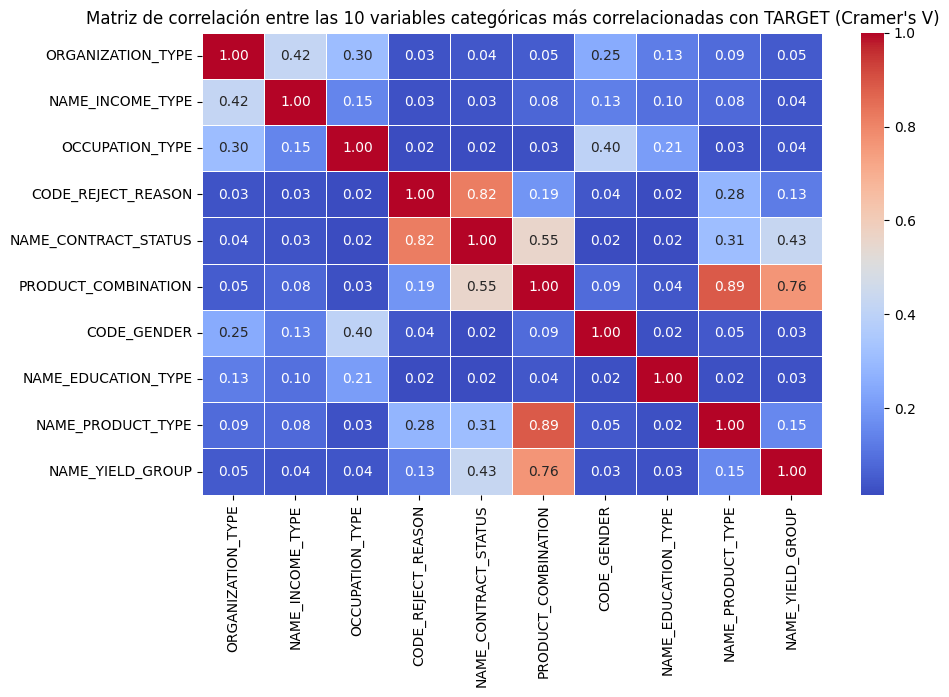

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Seleccionar las 10 variables categóricas más correlacionadas con TARGET
top_categorical_vars = chi2_df.head(10)  # Extrae las 10 más importantes
top_categorical_vars_list = top_categorical_vars["Variable"].tolist()

# Función para calcular Cramer's V
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2_stat / (n * (min(contingency_table.shape) - 1)))

# Seleccionar las 10 variables categóricas más correlacionadas con TARGET
top_categorical_vars_list = top_categorical_vars["Variable"].tolist() if isinstance(top_categorical_vars, pd.DataFrame) else top_categorical_vars.tolist()

# Crear matriz vacía para almacenar Cramer's V
cramers_v_matrix = pd.DataFrame(np.zeros((len(top_categorical_vars_list), len(top_categorical_vars_list))),
                                index=top_categorical_vars_list, columns=top_categorical_vars_list)

# Calcular Cramer's V para cada par de variables categóricas
for var1 in top_categorical_vars_list:
    for var2 in top_categorical_vars_list:
        if var1 == var2:
            cramers_v_matrix.loc[var1, var2] = 1.0  # 🔥 Asigna 1.0 en la diagonal principal
        else:
            cramers_v_matrix.loc[var1, var2] = cramers_v(train_final[var1], train_final[var2])

# Crear heatmap de correlación entre variables categóricas con Cramer's V
plt.figure(figsize=(10, 6))
sns.heatmap(cramers_v_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación entre las 10 variables categóricas más correlacionadas con TARGET (Cramer's V)")
plt.show()


## Interpretación del Heatmap de Cramér's V

El **heatmap de Cramér's V** muestra la correlación entre las 10 variables categóricas más relacionadas con **TARGET**. A partir del análisis, se destacan los siguientes puntos clave:

### **Alta correlación (>0.75)**
- **PRODUCT_COMBINATION - NAME_PRODUCT_TYPE (0.89)**: Fuerte relación, lo que indica que una de estas variables podría eliminarse para evitar multicolinealidad.
- **PRODUCT_COMBINATION - NAME_YIELD_GROUP (0.76)**: También presentan una fuerte dependencia, lo que sugiere información redundante.

### **Correlación moderada (0.5 - 0.75)**
- **NAME_CONTRACT_STATUS - CODE_REJECT_REASON (0.82)**: Es esperable, ya que el estado del contrato está influenciado por las razones de rechazo.
- **NAME_CONTRACT_STATUS - PRODUCT_COMBINATION (0.55)**: Sugiere una relación entre cómo los productos de crédito están agrupados según el estado del contrato.

### *Baja correlación (<0.5)**
- La mayoría de las demás combinaciones tienen valores bajos, indicando que no hay relaciones fuertes entre ellas y, por lo tanto, no generan un problema significativo de redundancia.

### **Conclusión**
Para **evitar problemas de multicolinealidad**, podemos:
- Eliminar **NAME_PRODUCT_TYPE** o **PRODUCT_COMBINATION**.
- Evaluar si **NAME_YIELD_GROUP** aporta información adicional o es redundante.
- Revisar la necesidad de incluir **CODE_REJECT_REASON** y **NAME_CONTRACT_STATUS**, ya que tienen una alta correlación entre sí.

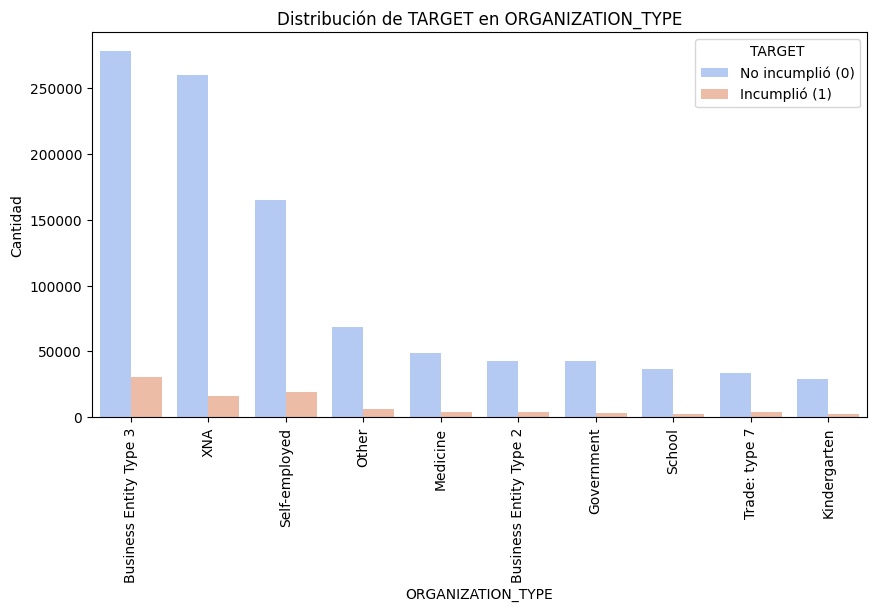

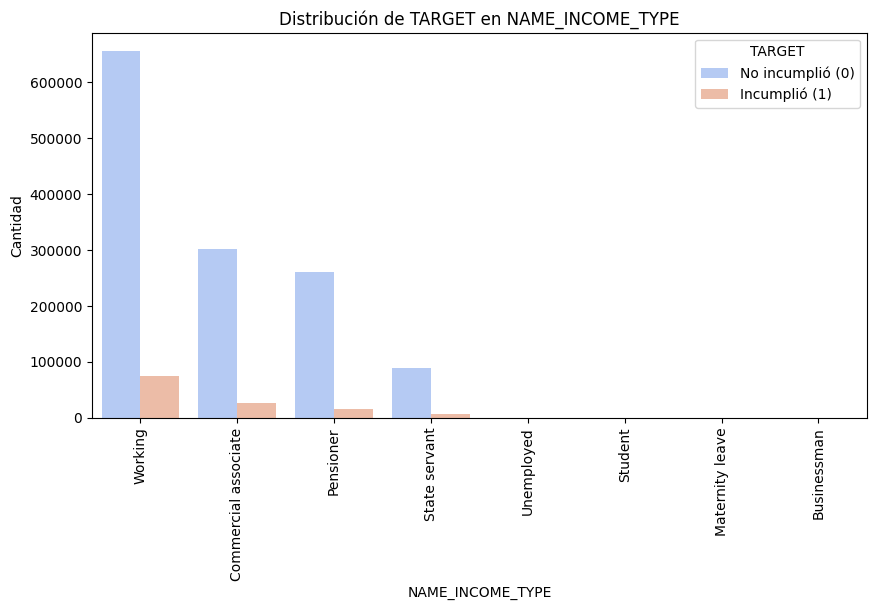

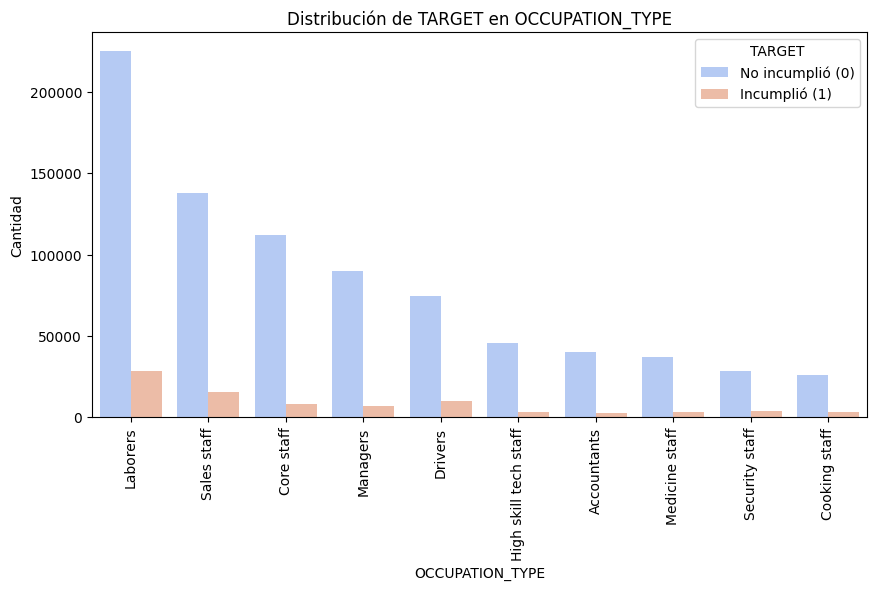

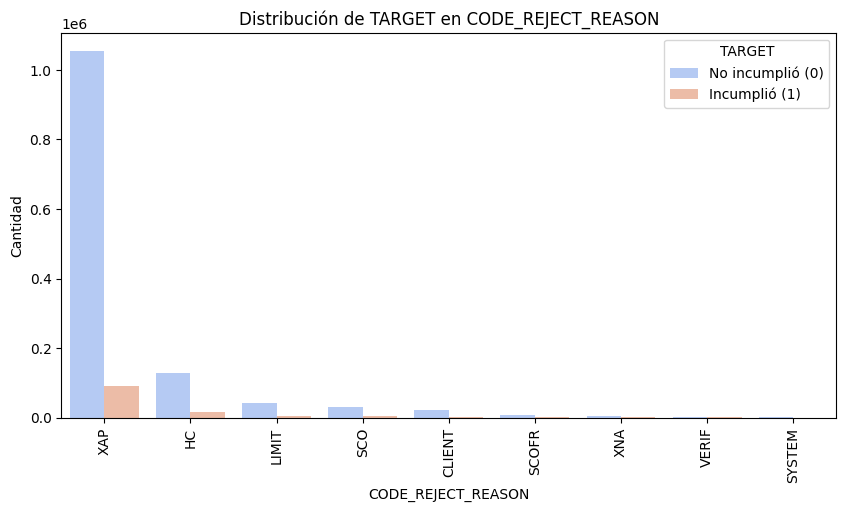

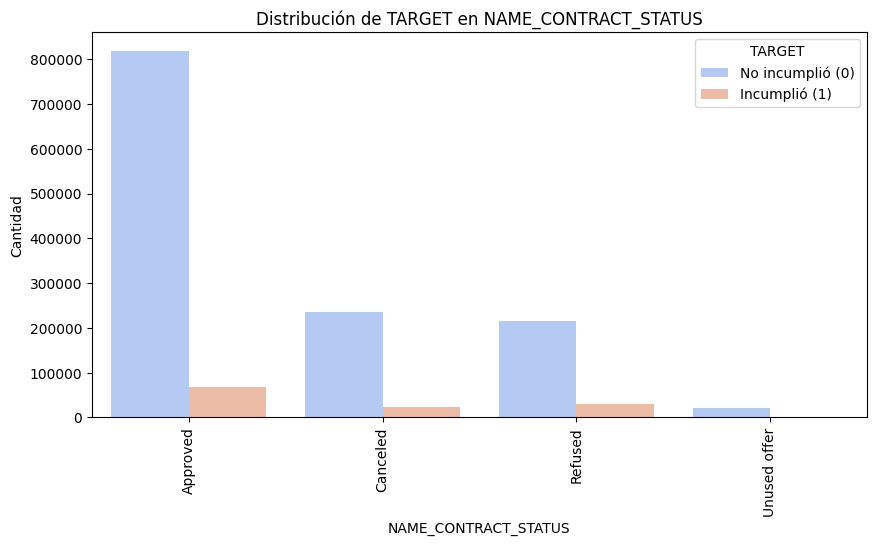

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las 5 variables categóricas más correlacionadas con TARGET
top_categorical_vars = chi2_df["Variable"].head(5).tolist()

# Verificar si las variables están en train_final
top_categorical_vars = [var for var in top_categorical_vars if var in train_final.columns]

# Generar gráficos individuales para cada variable categórica más correlacionada con TARGET
for var in top_categorical_vars:
    plt.figure(figsize=(10, 5))
    
    # Seleccionar las 10 categorías más frecuentes
    top_categories = train_final[var].value_counts().index[:10]
    
    # Filtrar el DataFrame para incluir solo esas categorías
    filtered_data = train_final[train_final[var].isin(top_categories)]
    
    # Graficar
    sns.countplot(data=filtered_data, x=var, hue="TARGET", palette="coolwarm", order=top_categories)
    
    plt.title(f"Distribución de TARGET en {var}")
    plt.xlabel(var)
    plt.ylabel("Cantidad")
    plt.legend(title="TARGET", labels=["No incumplió (0)", "Incumplió (1)"])
    plt.xticks(rotation=90)
    plt.show()



## Análisis de las Variables Categóricas más Correlacionadas con TARGET

Los gráficos muestran la distribución de la variable **TARGET** para las cinco variables categóricas más correlacionadas con el incumplimiento de pagos. En todos los casos, la mayoría de los clientes pertenecen a la categoría **TARGET = 0**, lo que indica que **la gran mayoría de los clientes han cumplido con sus pagos**. Sin embargo, algunos patrones destacan:

### 1. ORGANIZATION_TYPE  
- Los clientes que trabajan en ciertos sectores, como **Business Entity Type 3, Government y Electricity**, tienen una alta representación en la base de datos y también presentan ciertos niveles de incumplimiento, aunque siempre en menor proporción respecto a los cumplidores.

### 2. NAME_INCOME_TYPE  
- La mayoría de los clientes con ingresos provienen de la categoría **Working (trabajadores dependientes)**, seguida de **Commercial associate y Pensioner**.  
- Aunque en todas las categorías la proporción de incumplimiento es baja, se puede notar que los **desempleados y trabajadores informales** tienen una proporción ligeramente mayor de incumplimiento en comparación con otros grupos.

### 3. OCCUPATION_TYPE  
- Las ocupaciones más comunes son **Laborers, Core Staff y Accountants**, con la mayoría de los clientes cumpliendo con sus pagos.  
- Sin embargo, ciertas ocupaciones pueden presentar un mayor riesgo relativo de incumplimiento, como **Low-skill laborers y Waiters/Barmen staff**, aunque siguen siendo minoría dentro de sus respectivas categorías.

### 4. CODE_REJECT_REASON  
- La mayoría de los rechazos de crédito están etiquetados bajo la categoría **XAP**, que también muestra la mayor cantidad de incumplidores dentro del grupo.  
- Algunas otras razones, como **LIMIT y HC**, presentan una mayor proporción de incumplimiento en comparación con las demás razones de rechazo.

### 5. NAME_CONTRACT_STATUS  
- Los contratos **Approved** (aprobados) son la categoría predominante, con una gran mayoría de clientes que cumplen con sus pagos.  
- Sin embargo, en contratos **Canceled y Refused**, la proporción de incumplimiento es levemente más alta en comparación con los contratos aprobados.

## Conclusión  
Si bien **la gran mayoría de los clientes han cumplido con sus pagos (TARGET = 0)**, algunas categorías de ocupación, fuente de ingresos y tipo de organización presentan proporciones de incumplimiento ligeramente más altas. Estas diferencias pueden ser útiles para mejorar modelos predictivos de riesgo crediticio y ajustar estrategias de aprobación de crédito.
